## Import Necessary Packages

In [15]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## User-Defined Fields

In [2]:
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/pod/configs.json'
with open(CONFIGSPATH,'r',encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.0

## Functions

In [3]:
def create_log_rain_bins(binspacing=0.08,minleftedge=0.001,maxcenter=1000):
    firstcenter = minleftedge/(1-binspacing/2)
    center      = firstcenter
    bincenters  = []
    binwidths   = []
    while center<=maxcenter:
        width = center*(binspacing)
        bincenters.append(center)
        binwidths.append(width)
        center  = center*(1+binspacing)
    bincenters  = np.array(bincenters)
    binwidths   = np.array(binwidths)
    binedges    = np.zeros(len(bincenters)+1)
    binedges[0] = bincenters[0]-binwidths[0]/2
    for i in range(len(bincenters)):
        binedges[i+1] = bincenters[i]+binwidths[i]/2
    return binedges

def get_r2(ytrueflat,ypredflat):
    mu  = ytrueflat.mean()
    rss = np.sum((ytrueflat-ypredflat)**2)
    tss = np.sum((ytrueflat-mu)**2)
    r2  = 1.0-(rss/tss)
    return np.nan if tss==0 else r2

def get_r2_spatial(ytrue,ypred,prthresh,positive=False):
    if positive: 
        mask = (ytrue>0)
        ytrue = ytrue.where(mask)
        ypred = ypred.where(mask)
    mu  = ytrue.mean('time',skipna=True)
    rss = ((ytrue-ypred)**2).sum('time',skipna=True)
    tss = ((ytrue-mu)**2).sum('time',skipna=True)
    r2  = 1.0-(rss/tss)
    return r2

def get_confusion_counts(ytrueflat,ypredflat,prthresh):
    trueabove = ytrueflat>prthresh
    predabove = ypredflat>prthresh
    TP = int(np.sum(predabove&trueabove))
    FP = int(np.sum(predabove&~trueabove))
    FN = int(np.sum(~predabove&trueabove))
    TN = int(np.sum(~predabove&~trueabove))
    return TP,FP,FN,TN

## Load Data

In [4]:
truepath = os.path.join(FILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

results = {}
for run in RUNS:
    runname     = run['run_name']
    description = run.get('description', runname)
    predpath    = os.path.join(RESULTSDIR,f'pod_{runname}_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['predpr'].load()
    ytrue,ypred= xr.align(truepr,predpr,join='inner')
    results[runname] = dict(description=description,ytrue=ytrue,ypred=ypred)

## P-$B_L$ Relationships

In [5]:
curves = []
for run in RUNS:
    runname     = run['run_name']
    description = run.get('description',runname)
    npzpath     = os.path.join(MODELDIR,f'pod_{runname}.npz')
    with np.load(npzpath) as data:
        bincenters = data['bincenters'].astype(np.float32)
        binmeans   = data['binmeans'].astype(np.float32)
        nparams    = int(np.isfinite(binmeans).sum())
    curves.append(dict(runname=runname,description=description,bincenters=bincenters,binmeans=binmeans,nparams=nparams))

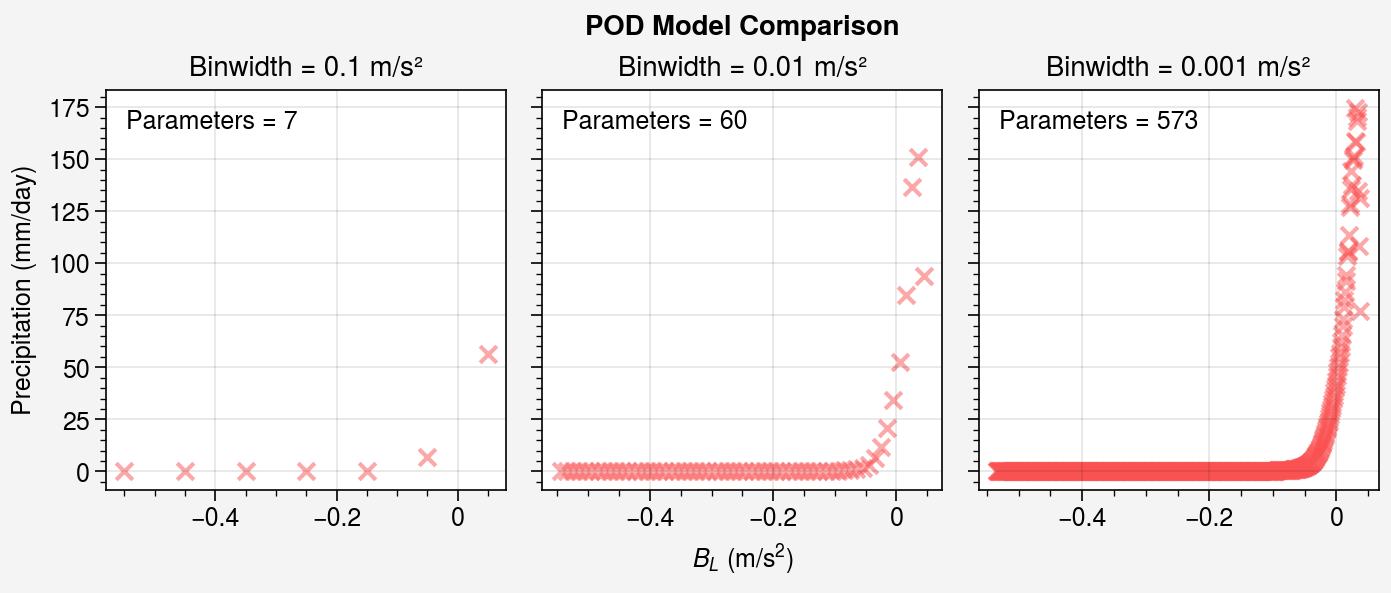

In [6]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=True)
for i,curve in enumerate(curves):
    mask = np.isfinite(curve['binmeans'])
    axs[i].scatter(curve['bincenters'][mask],curve['binmeans'][mask],color='red6',marker='x',alpha=0.5)
    axs[i].format(title=curve['description'])
    axs[i].text(0.05,0.95,f'Parameters = {curve["nparams"]}',transform=axs[i].transAxes,va='top')
axs.format(suptitle='POD Model Comparison',xlabel='$\mathit{B_L}$ (m/s$^{2}$)',ylabel='Precipitation (mm/day)')
pplt.show()

## Observed vs. Predicted Precipitation

In [7]:
binedges  = create_log_rain_bins()
globalmin = float(binedges[0])
globalmax = float(binedges[-1])

paneldata  = [] 
for runname,result in results.items():
    description = result['description']
    ytrueflat   = result['ytrue'].values.ravel()
    ypredflat   = result['ypred'].values.ravel()
    mask = np.isfinite(ytrueflat)&np.isfinite(ypredflat)&(ytrueflat>0.0)
    r2   = get_r2(ytrueflat[mask],ypredflat[mask])
    hist,_,_   = np.histogram2d(ytrueflat[mask],ypredflat[mask],bins=[binedges,binedges])
    hist       = np.ma.masked_where(hist==0,hist)
    paneldata.append((description,hist,r2))

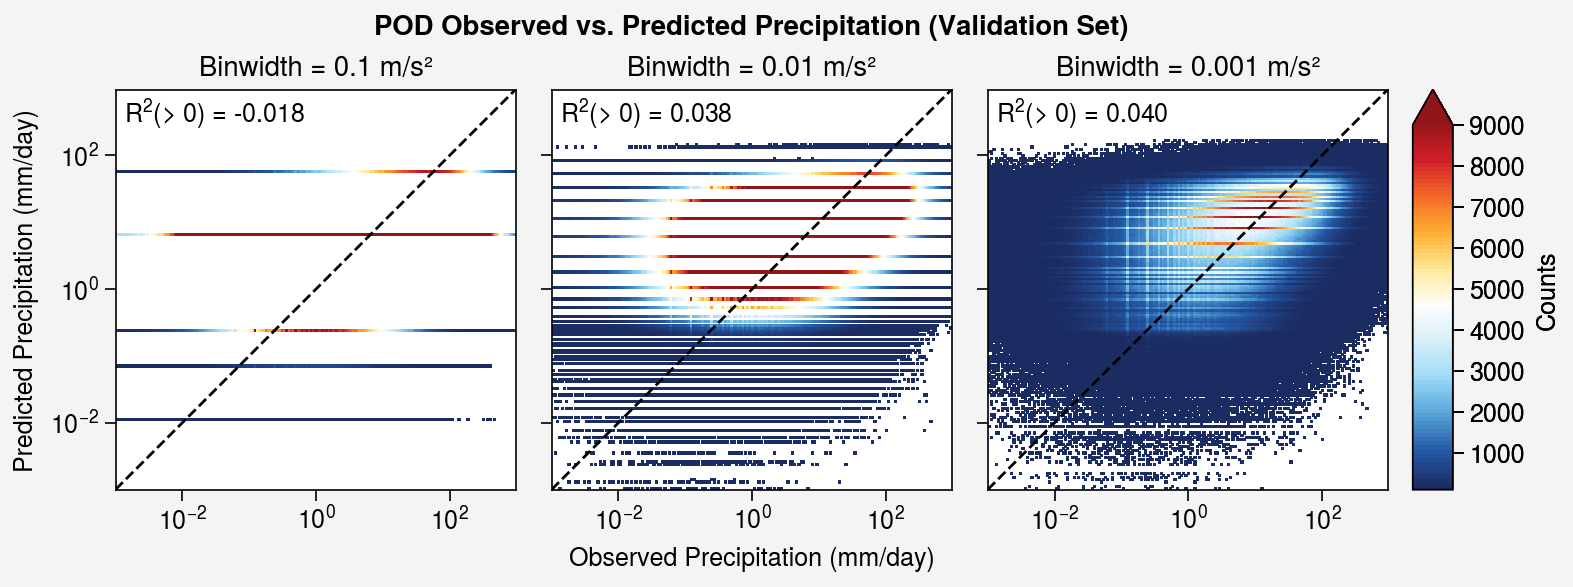

In [8]:
fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle='POD Observed vs. Predicted Precipitation (Validation Set)',
           xlabel='Observed Precipitation (mm/day)',xscale='log',xformatter='log',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log')

im = None
for ax,(description,hist,r2) in zip(axs,paneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=9000,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'R$^2$(> 0) = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,
              xlim=(globalmin,globalmax),xticks=[1e-4,1e-2,1e0,1e2],xminorticks='none',
              ylim=(globalmin,globalmax),yticks=[1e-4,1e-2,1e0,1e2],yminorticks='none')

fig.colorbar(im,loc='r',label='Counts',ticks=[1000,2000,3000,4000,5000,6000,7000,8000,9000])
pplt.show()

## Observed vs. Predicted Precipitation Distributions

In [9]:
binedges  = create_log_rain_bins()

paneldata  = [] 
for runname,result in results.items():
    description = result['description']
    ytrueflat = result['ytrue'].values.ravel()
    ypredflat = result['ypred'].values.ravel()
    mask = np.isfinite(ytrueflat)&np.isfinite(ypredflat)&(ytrueflat>0)
    r2   = get_r2(ytrueflat[mask],ypredflat[mask])
    paneldata.append((description,r2,ytrueflat,ypredflat))

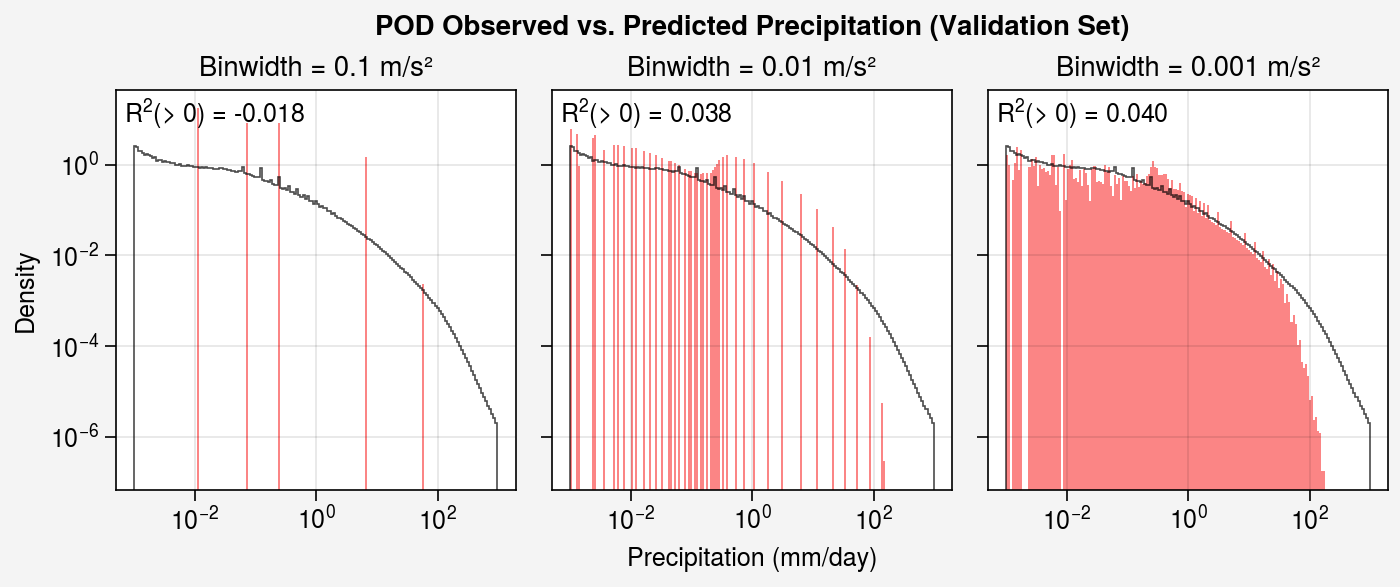

In [10]:
fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle='POD Observed vs. Predicted Precipitation (Validation Set)',
           xlabel='Precipitation (mm/day)',xscale='log',xformatter='log',ylabel='Density',yscale='log',yformatter='log')

for ax,(description,r2,ytrueflat,ypredflat) in zip(axs,paneldata):
    ax.hist(ytrueflat,bins=binedges,density=True,histtype='step',color='k',alpha=0.7,label='Observed')
    ax.hist(ypredflat,bins=binedges,density=True,color='red6',alpha=0.7,label='Predicted')
    ax.text(0.02,0.98,f'R$^2$(> 0) = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description)
    
pplt.show()

## Confusion Matrix

In [11]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrueflat   = result['ytrue'].values.ravel()
    ypredflat   = result['ypred'].values.ravel()
    mask        = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    TP,FP,FN,TN = get_confusion_counts(ytrueflat[mask],ypredflat[mask],PRTHRESH)
    total  = TP+FP+FN+TN
    matrix = 100.0*np.array([[TN,FP],[FN,TP]],dtype=float)/total
    paneldata.append((description,matrix,dict(TP=TP,FP=FP,FN=FN,TN=TN,total=total)))

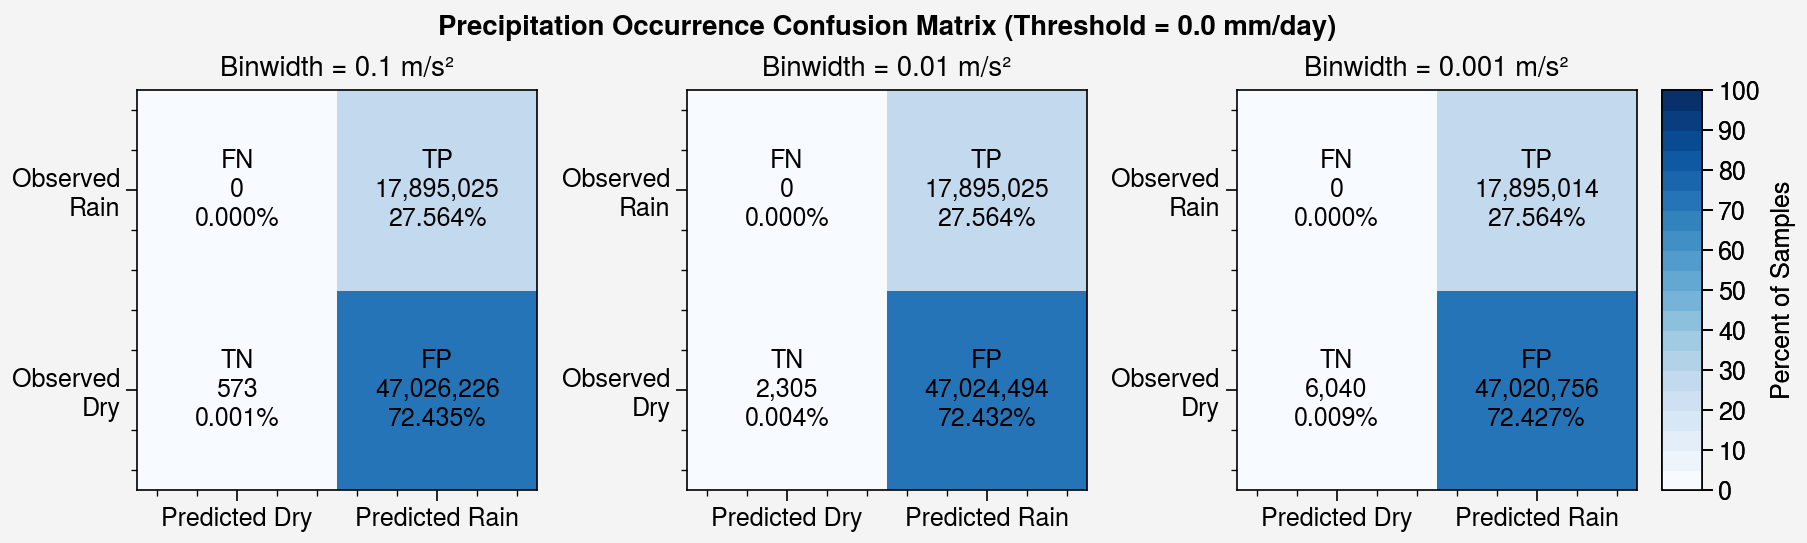

In [12]:
fig,axs = pplt.subplots(ncols=len(paneldata),refwidth=2,share=False)
axs.format(suptitle=f'Precipitation Occurrence Confusion Matrix (Threshold = {PRTHRESH} mm/day)')

im = None
for ax,(description,matrix,count) in zip(axs,paneldata):
    xedges = [0,1,2]
    yedges = [0,1,2]
    im = ax.pcolormesh(xedges,yedges,matrix,cmap='Blues',vmin=0,vmax=100,levels=21)
    labels = [
        ('TN',count['TN'],matrix[0,0],0.5,0.5),
        ('FP',count['FP'],matrix[0,1],1.5,0.5), 
        ('FN',count['FN'],matrix[1,0],0.5,1.5), 
        ('TP',count['TP'],matrix[1,1],1.5,1.5)]
    for label,value,percent,x,y in labels:
        ax.text(x,y,f'{label}\n{value:,}\n{percent:.3f}%',ha='center',va='center')
    ax.format(title=description,
              xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Rain'],xminorlocator=None,
              ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nRain'],yminorlocator=None)

fig.colorbar(im,loc='r',label='Percent of Samples')
pplt.show()

## $\mathrm{R^2}$ Maps

In [13]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    mask  = np.isfinite(ytrue)&np.isfinite(ypred)
    r2all = get_r2_spatial(ytrue.where(mask),ypred.where(mask),PRTHRESH,positive=False)
    r2pos = get_r2_spatial(ytrue.where(mask),ypred.where(mask),PRTHRESH,positive=True)
    paneldata.append((description,r2all,r2pos))

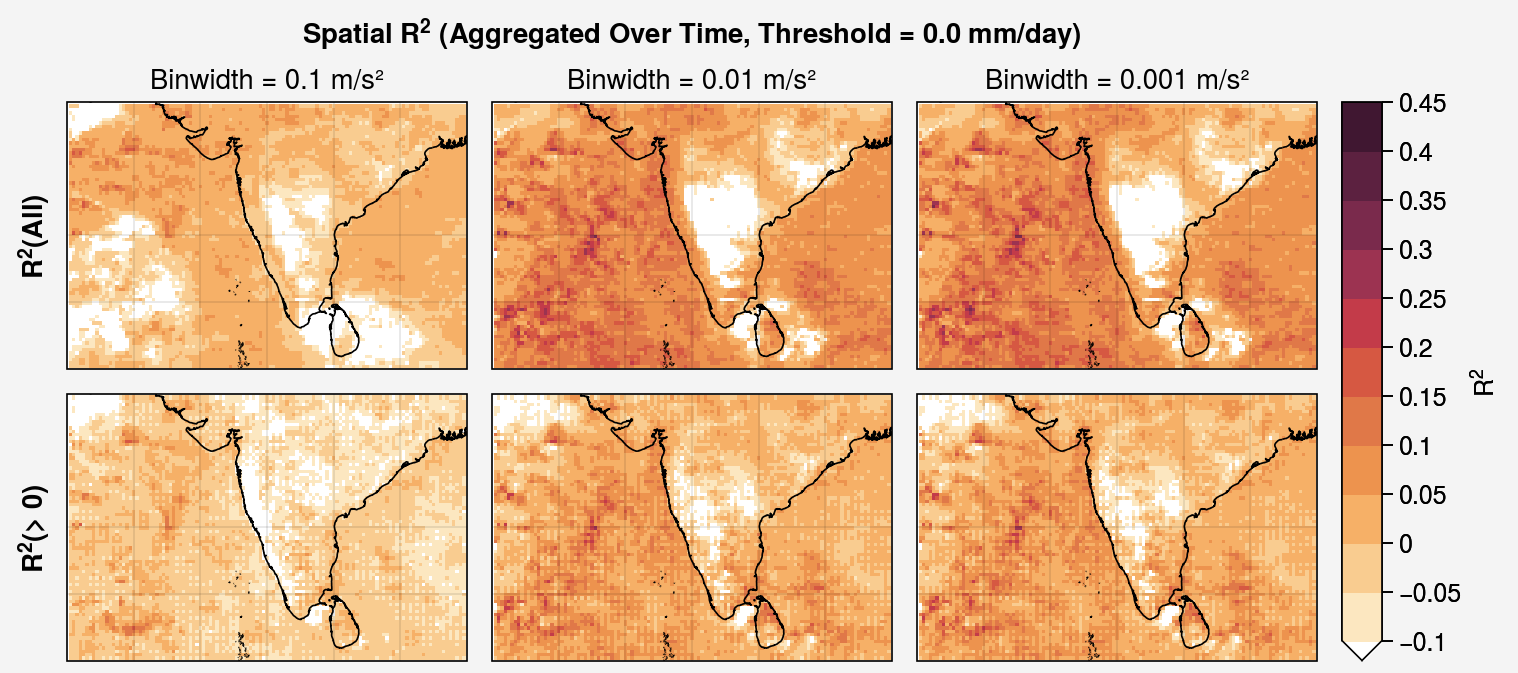

In [14]:
fig,axs = pplt.subplots(nrows=2,ncols=len(paneldata),refwidth=2,proj='cyl',share=False)
axs.format(suptitle=f'Spatial R$^2$ (Aggregated Over Time, Threshold = {PRTHRESH} mm/day)',rowlabels=['R$^2$(All)','R$^2$(> 0)'],
           coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)

im = None
for col,(description,r2all,r2pos) in enumerate(paneldata):
    for row,da in enumerate([r2all,r2pos]):
        ax = axs[row,col]
        im = ax.pcolormesh(da.lon,da.lat,da,cmap='Fire',vmin=-0.1,vmax=0.5,levels=14,extend='min')
        if row==0:
            ax.format(title=description)
fig.colorbar(im,loc='r',label='R$^2$')
pplt.show()